<a href="https://colab.research.google.com/github/AndresChavez123/SenalesySistemas/blob/main/Parcial1_SyS/Parcial1_Ejercicio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Análisis de una señal triangular y su derivada**

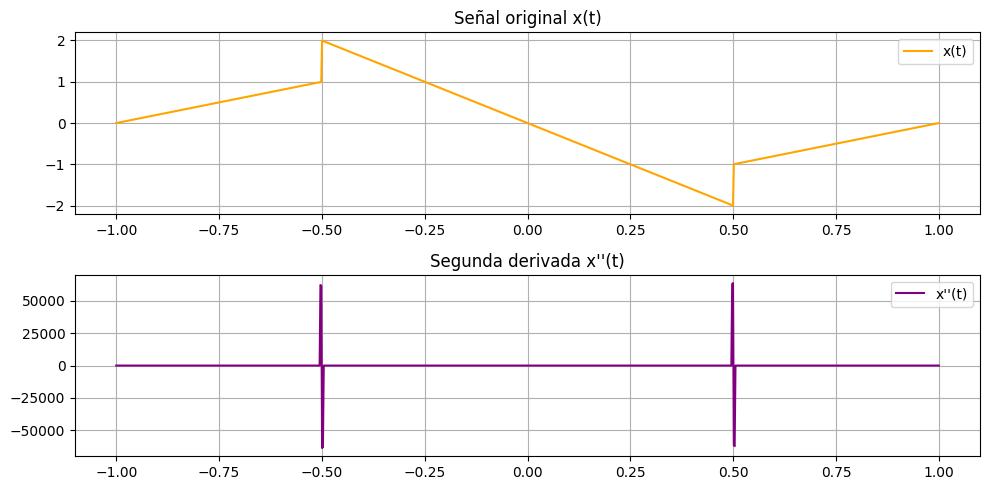

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson  # Se puede usar para integración más precisa más adelante

# -----------------------------------------------
# 1. Parámetros fundamentales
# -----------------------------------------------

T = 2              # Periodo de la señal
ti, tf = -1, 1     # Intervalo de tiempo de un periodo completo
w0 = 2 * np.pi / T # Frecuencia fundamental de la señal periódica
N = 1000           # Número de muestras para discretización fina
t = np.linspace(ti, tf, N)  # Vector de tiempo
dt = t[1] - t[0]   # Paso de muestreo temporal

# -----------------------------------------------
# 2. Definición de la señal x(t) (triangular)
# -----------------------------------------------

# La función piecewise define la señal a trozos:
# - En t < -0.5: rampa creciente desde -1 hasta -0.5
# - En -0.5 ≤ t ≤ 0.5: rampa decreciente
# - En t > 0.5: rampa creciente nuevamente
def x_t(t):
    return np.piecewise(t,
        [t < -0.5, (t >= -0.5) & (t <= 0.5), t > 0.5],
        [lambda t: 2 * (t + 1),
         lambda t: -4 * t,
         lambda t: 2 * (t - 1)])

# -----------------------------------------------
# 3. Derivadas numéricas de x(t)
# -----------------------------------------------

x_vals = x_t(t)                 # Evaluamos x(t) en los puntos del tiempo
dx = np.gradient(x_vals, dt)    # Primera derivada numérica usando diferencias finitas
d2x = np.gradient(dx, dt)       # Segunda derivada numérica (x''(t))

# -----------------------------------------------
# 4. Visualización de la señal y su segunda derivada
# -----------------------------------------------

plt.figure(figsize=(10, 5))

# Gráfico de x(t)
plt.subplot(2, 1, 1)
plt.plot(t, x_vals, label='x(t)', color='orange')
plt.grid()
plt.legend()
plt.title("Señal original x(t)")

# Gráfico de x''(t)
plt.subplot(2, 1, 2)
plt.plot(t, d2x, label="x''(t)", color='purple')
plt.grid()
plt.legend()
plt.title("Segunda derivada x''(t)")

plt.tight_layout()
plt.show()

# Comentario final:
# La segunda derivada de la señal triangular presenta discontinuidades importantes
# (picos y valles muy pronunciados), que corresponden a los puntos angulosos de la señal original.
# Estos valores serán clave si queremos estimar los coeficientes de Fourier mediante x''(t).


** Reconstrucción de la señal x(t) desde sus coeficientes cn**

<ipython-input-3-2655202529>:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integrando, t)


Error relativo de reconstrucción: 0.1573


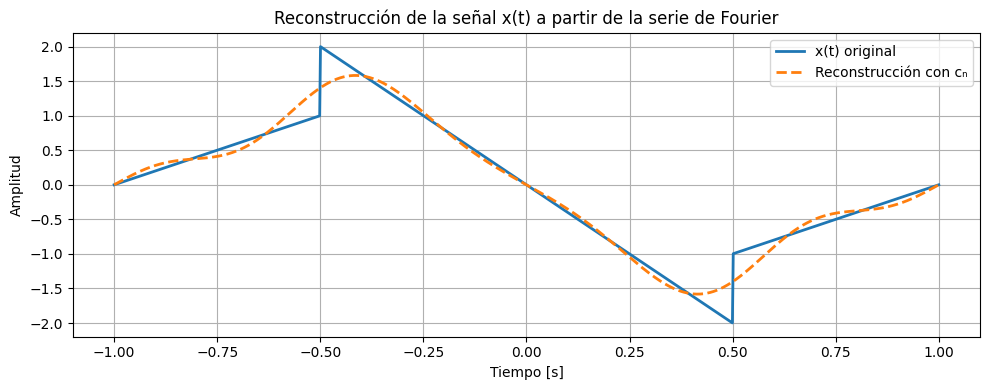

In [3]:

# ipython-input-2-681139883

# Creamos un vector complejo para ir sumando las componentes de la serie de Fourier
x_recon = np.zeros_like(t, dtype=complex)

# =================================================
# Cálculo de coeficientes de Fourier cn (MOVIDO DE LA SIGUIENTE CELDA)
# Esto es necesario para poder reconstruir la señal.
# =================================================

# Definición de la señal x(t) tipo "trapezoide invertido" si esta es la señal deseada,
# o usar x_vals si la señal triangular es la deseada.
# Basándonos en la primera celda que define x_t(t), usaremos x_vals.
# Si se quiere usar la señal trapezoide invertido, descomentar la línea de abajo
# x = np.piecewise(t, [t < -0.5, (t >= -0.5) & (t <= 0.5), t > 0.5], [0, -1, 0])
# y recalcular x2 = np.gradient(np.gradient(x, dt), dt)

# Usamos la segunda derivada d2x calculada previamente para la señal triangular
x2 = d2x

n_vals = np.arange(-5, 6) # Rango de n para los coeficientes
c_n = []
for n in n_vals:
    if n == 0:

        c0_val = np.mean(x_vals)
        c_n.append(c0_val)
    else:
        # Fórmula para cn usando la segunda derivada: cn = Integral(x''(t) * exp(-j*n*w0*t) dt) / (-n^2 * w0^2 * T)
        # Estamos integrando sobre un periodo T = tf - ti
        integrando = x2 * np.exp(-1j * n * w0 * t)
        # Usamos np.trapz para la integración numérica
        integral = np.trapz(integrando, t)
        cn = integral / ((-n**2) * w0**2 * (tf - ti))
        c_n.append(cn)

c_n = np.array(c_n)

# Sumamos los términos de la serie exponencial de Fourier:
# x(t) ≈ sum_{n=min_n}^{max_n} c_n * exp(j * n * w0 * t)
# Usamos x_recon = sum(cn * exp(j*n*w0*t)) para evitar la acumulación de error si se suma en el loop.
x_recon = np.sum([cn * np.exp(1j * n * w0 * t) for n, cn in zip(n_vals, c_n)], axis=0)


# =================================================
# Cálculo del error relativo de reconstrucción
# =================================================

# El error relativo se calcula como:
# ||x(t) - x_recon(t)|| / ||x(t)|| en norma L2
# Usamos la parte real de la reconstrucción (porque los valores imaginarios son por errores numéricos pequeños)
error_rel = np.linalg.norm(x_vals - x_recon.real) / np.linalg.norm(x_vals)

# Mostramos el error en consola
print(f"Error relativo de reconstrucción: {error_rel:.4f}")

# =================================================
# Gráfica de comparación entre x(t) y su reconstrucción
# =================================================

plt.figure(figsize=(10, 4))
plt.plot(t, x_vals, label='x(t) original', linewidth=2)
plt.plot(t, x_recon.real, '--', label='Reconstrucción con cₙ', linewidth=2)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Reconstrucción de la señal x(t) a partir de la serie de Fourier")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Comentario:
# Si el número de armónicos usados (valores de n) es suficiente, la reconstrucción es muy precisa,
# especialmente en regiones suaves de la señal. El error relativo muestra cuán buena es la aproximación.



**Visualización del espectro y error relativo.**

<ipython-input-4-3573111572>:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integrando, t)


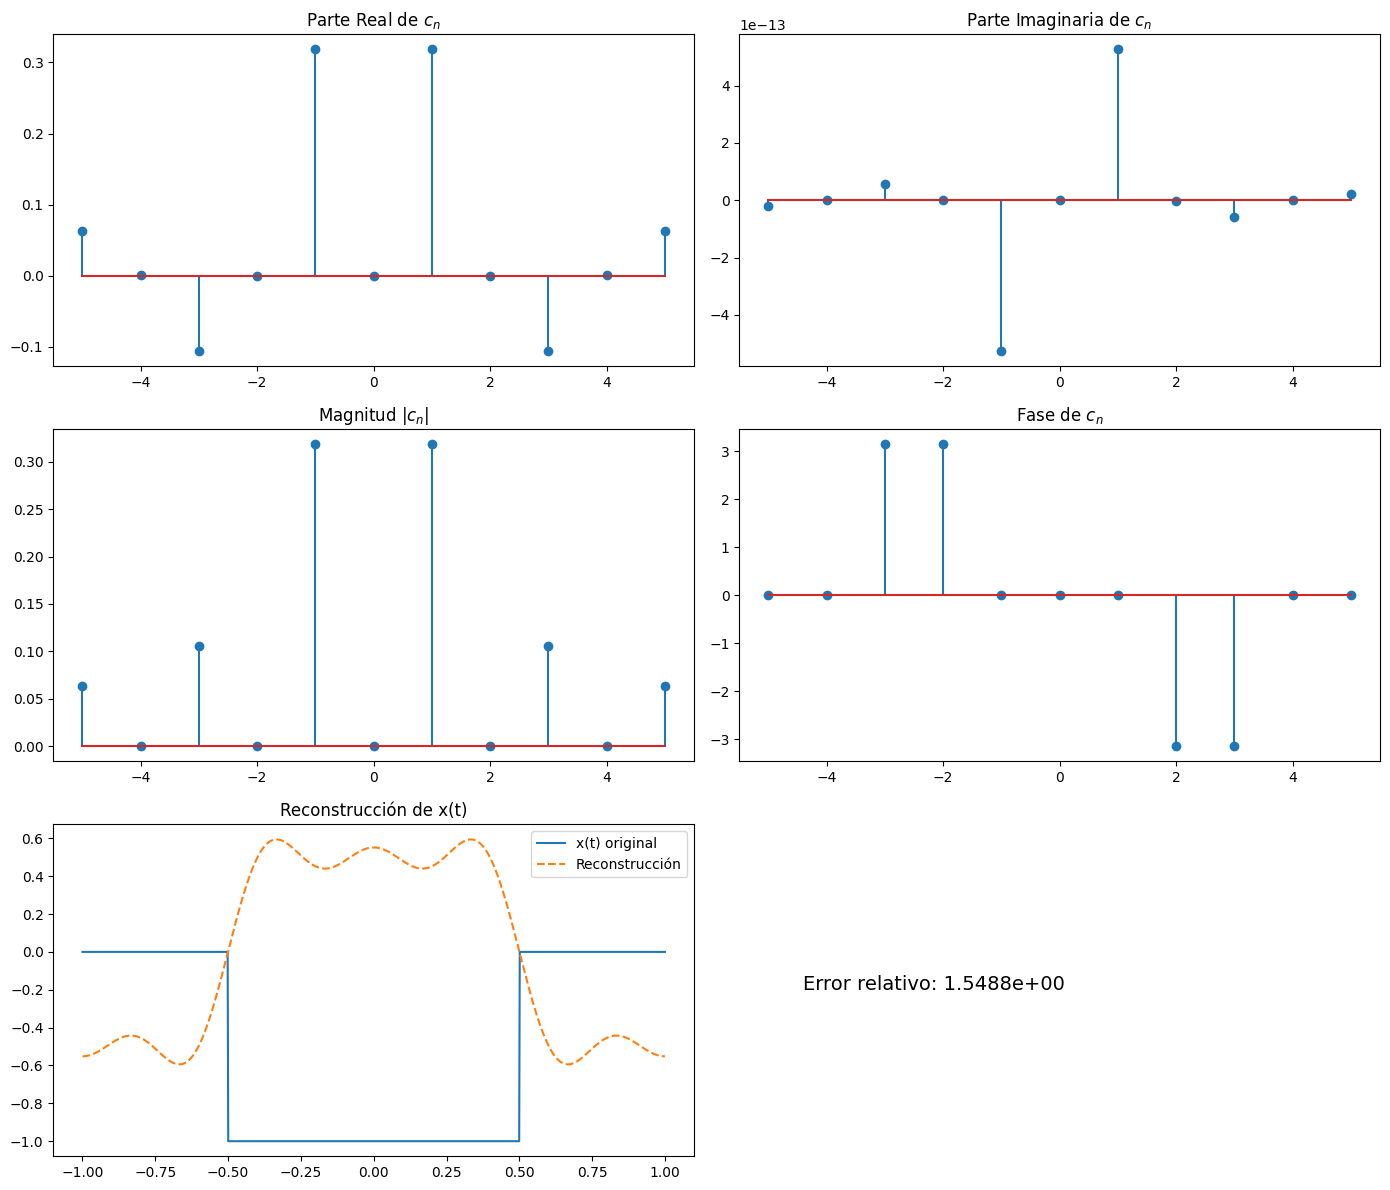

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
T = 2                      # Periodo de la señal
ti, tf = -1, 1             # Intervalo de tiempo
N = 1000                   # Número de muestras
t = np.linspace(ti, tf, N) # Vector de tiempo
w0 = 2 * np.pi / T         # Frecuencia fundamental
dt = t[1] - t[0]           # Paso temporal

# Definición de la señal x(t) tipo "trapezoide invertido"
x = np.piecewise(t,
                 [t < -0.5, (t >= -0.5) & (t <= 0.5), t > 0.5],
                 [0, -1, 0])

# Segunda derivada numérica
x2 = np.gradient(np.gradient(x, dt), dt)

# Cálculo de coeficientes de Fourier cn a partir de x''(t)
n_vals = np.arange(-5, 6)
c_n = []
for n in n_vals:
    if n == 0:
        c_n.append(0)  # Evita división por cero
    else:
        integrando = x2 * np.exp(-1j * n * w0 * t)
        integral = np.trapz(integrando, t)
        cn = integral / ((tf - ti) * (n**2) * w0**2)
        c_n.append(cn)
c_n = np.array(c_n)

# Magnitud, fase y componentes
mag = np.abs(c_n)
fase = np.angle(c_n)
parte_real = np.real(c_n)
parte_imag = np.imag(c_n)

# Reconstrucción de x(t) desde los coeficientes
x_rec = np.sum([cn * np.exp(1j * n * w0 * t) for n, cn in zip(n_vals, c_n)], axis=0)

# Cálculo del error relativo
error = np.linalg.norm(x - x_rec.real) / np.linalg.norm(x)

# Gráficas
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

axs[0, 0].stem(n_vals, parte_real)
axs[0, 0].set_title("Parte Real de $c_n$")

axs[0, 1].stem(n_vals, parte_imag)
axs[0, 1].set_title("Parte Imaginaria de $c_n$")

axs[1, 0].stem(n_vals, mag)
axs[1, 0].set_title("Magnitud $|c_n|$")

axs[1, 1].stem(n_vals, fase)
axs[1, 1].set_title("Fase de $c_n$")

axs[2, 0].plot(t, x, label='x(t) original')
axs[2, 0].plot(t, x_rec.real, '--', label='Reconstrucción')
axs[2, 0].legend()
axs[2, 0].set_title("Reconstrucción de x(t)")

axs[2, 1].axis('off')
axs[2, 1].text(0.1, 0.5, f"Error relativo: {error:.4e}", fontsize=14)

plt.tight_layout()
plt.show()
